In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import Cauchy, Morlet
from scipy import signal

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
B1 = data + 10 *np.sin(2 * np.pi * 5 * t) #+ 50 * signal.square(2 * np.pi * 12.5 * t)
B2 = data + 400 *np.sin(2 * np.pi * 5 * t) #+ 10*signal.square(2 * np.pi * 12.5 * t)
B = np.vstack((B1,B2))
print(B.shape)

(2, 5000)


#### Create Transform Object and Analysis Filters

In [14]:
# Initializing the Transform object automatically forms the analysis and synthesis filter bank during __init__
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Morlet(),
    pad_method='symmetric', # Padding method for the convolution calls np.pad. Set to None if no padding
    b= 1,
    Mc= 1,
)

#### Transform


In [15]:
# Perform forward wavelet transform
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

In [16]:
result2 = transform.inverse(w2)

141.286604601524
(36.7638431703321+0.26731854296469826j) (1449.0393182192452+0.26731854296469754j) (39.41276343816886-0.2793082297180895j)


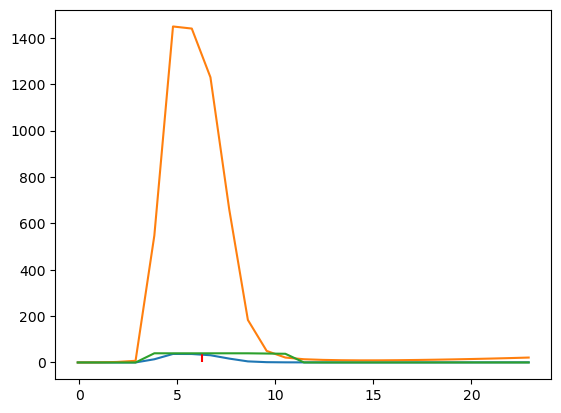

In [17]:
%matplotlib inline
dw = w2-w1
wc1 = np.sum(dw*w1.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)
wc2 = np.sum(dw*w2.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)


k_hat_real = np.where(
    np.abs(wc1) > np.percentile(np.abs(wc1), 50),
    np.abs((wc2)) / np.abs((wc1)),
    0
)

w_clean_real = ((np.tile(k_hat_real,(w1.shape[-1],1)).T*w1)-w2)/(np.tile(k_hat_real,(w1.shape[-1],1)).T-1)
result = transform.inverse(w_clean_real)
print(np.sqrt(((data-result)**2).mean(axis=0)))

plt.plot(transform.channel_freqs, wc1)
plt.plot(transform.channel_freqs, wc2)
plt.plot(transform.channel_freqs, k_hat_real)
plt.vlines(6.25, 0, np.max(k_hat_real), colors='r', linestyles='dashed')
print(np.max(wc1), np.max(wc2),np.max(wc2)/np.max(wc1))




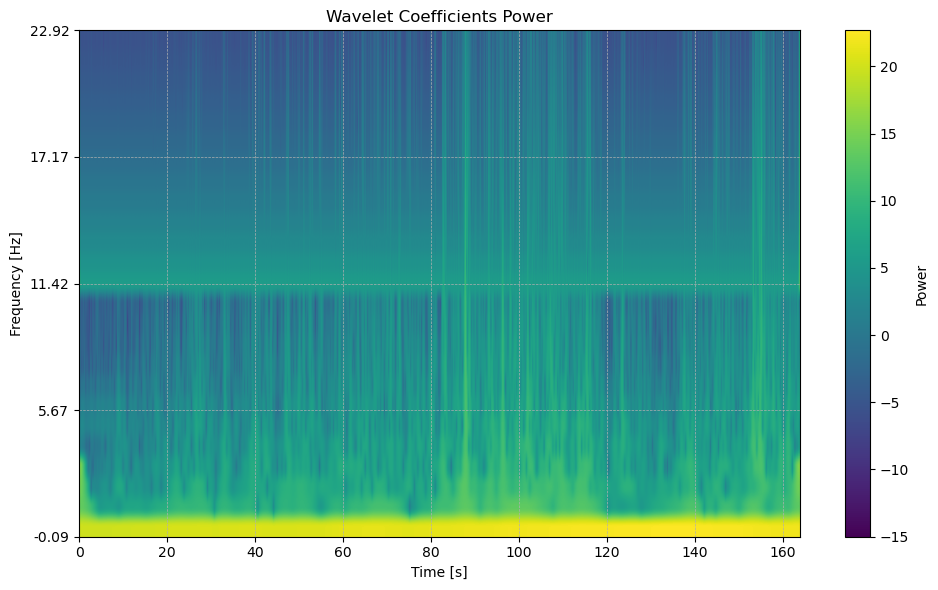

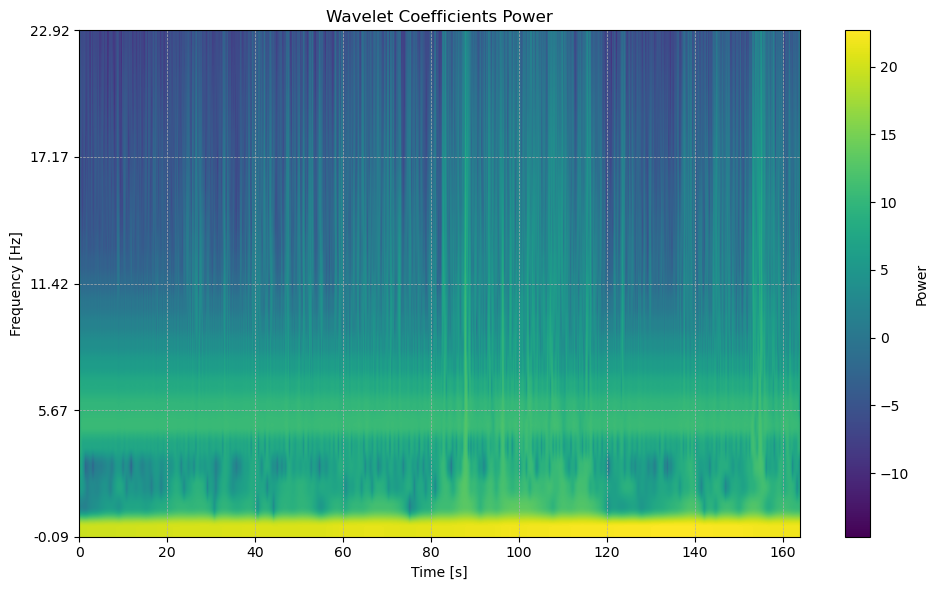

In [18]:
transform.power_scalogram(w_clean_real)
transform.power_scalogram(w1)

#### Compare to Normal WAICUP

(2.3740063958143107+0j)


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


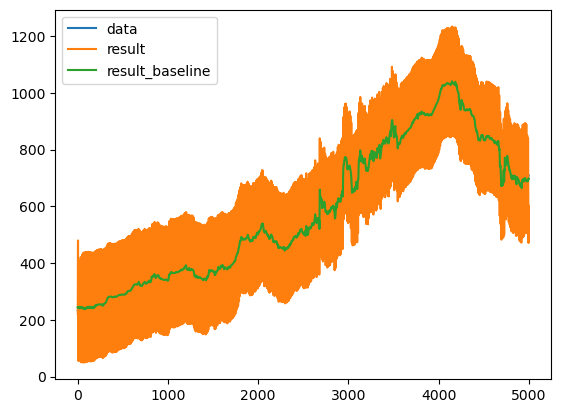

In [19]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result')
plt.plot(result_baseline, label='result_baseline')
plt.legend()

In [19]:
from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

In [43]:
transform.channel_freqs.shape

(241,)

In [41]:
int((1/transform.dj) * np.log2(5000 /transform.fs / (2 / transform.fs)))

225

In [52]:
s_max = 10/(transform.N/transform.fs)
J = int(np.ceil(np.log2(s_max / (2 / transform.fs)) / transform.dj))
J

13

In [56]:
np.log2(s_max / (2 / transform.fs)) / transform.dj

12.192809488736232

In [57]:
np.log2(5000)


12.287712379549449